## CM3005 Data Science<br/>Midterm Report<br/>Jaslyn Chan<br/>Student ID: 240662387
***

### 1.0 Domain and Objectives
#### 1.1 Domain-Specific Area
This project is situated within the domain of financial time-series analysis, specifically the analysis of long-term trends in a diversified equity portfolio. Financial markets have large volumes of time-dependant data, making them a useful area for statistical analysis and machine learning techniques. 

I selected the portfolio based on a weighted combination of major US market indices and technology stocks, that has both broad market exposure and individual equity performance. These types of portfolios are commonly analysed to understand growth patterns, volatility behaviour, and the impact of market-wide events over time. This makes the domain very suited for studying regression trends.

#### 1.2 Rationale for Using Linear Regression
Linear regression is used as a baseline model for financial contexts to identify long-term trends because despite short-term volatility and non-linear fluctuations, aggregated portfolio values usually have smoother behaviour over the long term. This makes linear regression an appropriate starting point for modelling portfolio growth as a function of time.

The purpose of using linear regression in this project is not to exact predictions or investment recommendations, but to evaluate whether a simple, interpretable model can capture the dominant trend in portfolio performance.

#### 1.3 Project Objectives
This project evaluates the suitability of linear regression as a baseline model for analysing long-term trends in a diversified equity portfolio using historical financial data. I aim to construct a pre-process a real-world financial dataset, analyse the volatility and distribution ,then visualise the trends. I will implement and evaluate regression models and compare it with a more complex polynomial model to assess trade-offs between accuracy and interpretability.

#### 1.4 Expected Contribution
This project shows how classical machine learning techniques, such as linear regression, can be applied meaningfully to financial time-series data when used for trend analysis rather than short-term prediction. The findings reveal the pros and cons, as well as limitations of linear regression in capturing portfolio-level behaviour and show how diversification improves model stability. The methodology can be transferred to other domains that also use time-series data over a long time.

### 2.0 Dataset Description

#### 2.1 Data Source
The dataset was obtained from Yahoo Finance, a widely used financial data platform that gives historical market data. Yahoo Finance is used in academic and industry context for analysis and it is a reliable site for studying trends.

#### 2.2 Dataset Composition
The dataset consists of four financial instruments
- S&P 500 Index
- NASDAQ-100 Index
- Apple Inc. (AAPL) stock
- Microsoft Corporation (MSFT) stock

#### 2.3 Dataset Structure and Size
Each CSV file has around 2,700 daily observations between January 2015 to December 2025. The use of multiple CSV files means the dataset was not initially in First Normal Form (1NF), requiring transformation during the data preparation stage. After pre-processing and merging, the final dataset consists of a single time-series table where each row represents one trading day and each column represents an individual asset or the constructed portfolio.

#### 2.4 Data Types
The raw data includes date fields and numerical variables such as opening price, closing price, adjusted closing price, and trading volume. I retained only the date and adjusted closing price. Adjusted closing price refers to actions like stock splits and dividends.

#### 2.5 Suitability for Linear Regression
The dataset has a clear long-term trend that is suitable for regression. The dataset also contains real-world imperfections, such as missing values and differing trading calendars, which requires pre-processing.

### 3.0 Data Preparation

#### 3.1 Data Acquisition and Initial Inspection
I retrieved the data from Yahoo Finance using the Python `yfinance` library.

The data was downloaded as separate CSV files to reflect real-world financial data acquisition practices, where data is often gathered from different places. Each CSV contains daily observations including open, high, low, close, adjusted close prices and trading volume.

In [54]:
# Install dependency required for Yahoo Finance data acquisition (run once)
%pip install -q yfinance

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import skew, kurtosis

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


Note: you may need to restart the kernel to use updated packages.


In [55]:
# -------------------------------
# 3.1 Data acquisition (Yahoo Finance)
# -------------------------------

# Directory for raw CSV downloads
RAW_DIR = "data_raw"
os.makedirs(RAW_DIR, exist_ok=True)

# Study period (end date is exclusive in yfinance, but works as intended for daily data)
START_DATE = "2015-01-01"
END_DATE   = "2025-12-22"

# Symbols used to download the portfolio components
tickers = {
    "SP500": "^GSPC",
    "NASDAQ": "^NDX",
    "AAPL": "AAPL",
    "MSFT": "MSFT"
}

def download_and_save(symbol: str, out_name: str) -> None:
    """Download daily price data for a symbol and save it as a CSV in RAW_DIR."""
    df = yf.download(
        symbol,
        start=START_DATE,
        end=END_DATE,
        interval="1d",
        auto_adjust=False,
        progress=False,
        group_by="column"
    )

    # Move index (date) into a normal column for CSV storage
    df = df.reset_index()

    # Flatten MultiIndex columns (sometimes returned by yfinance)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if col[0] != "" else col[1] for col in df.columns]

    # Standardise column names for consistent downstream processing
    df.columns = [str(c).strip().replace(" ", "_") for c in df.columns]

    out_path = os.path.join(RAW_DIR, f"{out_name}.csv")
    df.to_csv(out_path, index=False)
    print(f"Saved {out_name}: {df.shape}")

# Download and store each asset as a separate CSV (multi-file dataset)
for name, sym in tickers.items():
    download_and_save(sym, name)


Saved SP500: (2759, 7)
Saved NASDAQ: (2759, 7)
Saved AAPL: (2759, 7)
Saved MSFT: (2759, 7)


In [56]:
# Quick inspection of downloaded files
for f in os.listdir(RAW_DIR):
    df_tmp = pd.read_csv(os.path.join(RAW_DIR, f))
    print(f, df_tmp.shape)
    display(df_tmp.head())
    

AAPL.csv (2759, 7)


,Date,Adj_Close,Close,High,Low,Open,Volume
0,2015-01-02,24.237549,27.332500,27.860001,26.837500,27.847500,212818400
1,2015-01-05,23.554741,26.562500,27.162500,26.352501,27.072500,257142000
2,2015-01-06,23.556961,26.565001,26.857500,26.157499,26.635000,263188400
3,2015-01-07,23.887276,26.937500,27.049999,26.674999,26.799999,160423600
4,2015-01-08,24.805084,27.972500,28.037500,27.174999,27.307501,237458000


MSFT.csv (2759, 7)


,Date,Adj_Close,Close,High,Low,Open,Volume
0,2015-01-02,39.858452,46.759998,47.419998,46.540001,46.660000,27913900
1,2015-01-05,39.491932,46.330002,46.730000,46.250000,46.369999,39673900
2,2015-01-06,38.912289,45.650002,46.750000,45.540001,46.380001,36447900
3,2015-01-07,39.406685,46.230000,46.459999,45.490002,45.980000,29114100
4,2015-01-08,40.565960,47.590000,47.750000,46.720001,46.750000,29645200


NASDAQ.csv (2759, 7)


,Date,Adj_Close,Close,High,Low,Open,Volume
0,2015-01-02,4230.240234,4230.240234,4276.709961,4206.459961,4258.600098,1435150000
1,2015-01-05,4160.959961,4160.959961,4210.959961,4151.850098,4206.549805,1794470000
2,2015-01-06,4110.830078,4110.830078,4176.259766,4090.330078,4174.779785,2167320000
3,2015-01-07,4160.000000,4160.000000,4169.970215,4126.390137,4139.850098,1957950000
4,2015-01-08,4240.549805,4240.549805,4247.930176,4192.629883,4195.490234,2105450000


SP500.csv (2759, 7)


,Date,Adj_Close,Close,High,Low,Open,Volume
0,2015-01-02,2058.199951,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
1,2015-01-05,2020.579956,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2,2015-01-06,2002.609985,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
3,2015-01-07,2025.900024,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
4,2015-01-08,2062.139893,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


#### 3.2 Data Cleaning

In [57]:
# ---------------
# 3.2 Cleaning
# ---------------

FILES = {
    "SP500": os.path.join(RAW_DIR, "SP500.csv"),
    "NASDAQ": os.path.join(RAW_DIR, "NASDAQ.csv"),
    "AAPL": os.path.join(RAW_DIR, "AAPL.csv"),
    "MSFT": os.path.join(RAW_DIR, "MSFT.csv"),
}

def load_clean_price_series(path: str, series_name: str) -> pd.DataFrame:
    """Load one CSV, clean it, and return a tidy Date + Adjusted Close series."""
    df = pd.read_csv(path)

    # Standardise column names
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

    # Convert date column to datetime and sort chronologically
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).sort_values("date")

    # Ensure adjusted close exists (best practice for historical price analysis)
    if "adj_close" not in df.columns:
        raise ValueError(f"{series_name}: 'Adj Close' column not found. Columns = {df.columns.tolist()}")

    # Keep only atomic columns needed for analysis and rename to series_name
    out = df[["date", "adj_close"]].rename(columns={"adj_close": series_name})

    # Ensure numeric values and remove invalid rows
    out[series_name] = pd.to_numeric(out[series_name], errors="coerce")
    out = out.dropna(subset=[series_name])

    return out.reset_index(drop=True)

# Load and clean each time series independently (one DataFrame per asset)
series_list = []
for name, path in FILES.items():
    s = load_clean_price_series(path, name)
    print(name, s.shape, "from", os.path.basename(path))
    display(s.head())
    series_list.append(s)
    

SP500 (2759, 2) from SP500.csv


,date,SP500
0,2015-01-02,2058.199951
1,2015-01-05,2020.579956
2,2015-01-06,2002.609985
3,2015-01-07,2025.900024
4,2015-01-08,2062.139893


NASDAQ (2759, 2) from NASDAQ.csv


,date,NASDAQ
0,2015-01-02,4230.240234
1,2015-01-05,4160.959961
2,2015-01-06,4110.830078
3,2015-01-07,4160.000000
4,2015-01-08,4240.549805


AAPL (2759, 2) from AAPL.csv


,date,AAPL
0,2015-01-02,24.237549
1,2015-01-05,23.554741
2,2015-01-06,23.556961
3,2015-01-07,23.887276
4,2015-01-08,24.805084


MSFT (2759, 2) from MSFT.csv


,date,MSFT
0,2015-01-02,39.858452
1,2015-01-05,39.491932
2,2015-01-06,38.912289
3,2015-01-07,39.406685
4,2015-01-08,40.565960


#### 3.3 Transformation to First Normal Form (1NF)

In [58]:
# -------------------------------
# 3.3 1NF transformation
# -------------------------------

# Merge into a single 1NF table: one row per date, one column per asset
df_1nf = series_list[0]
for nxt in series_list[1:]:
    df_1nf = df_1nf.merge(nxt, on="date", how="outer")

df_1nf = df_1nf.sort_values("date").reset_index(drop=True)

# Handle missing values due to different trading calendars by forward-filling
price_cols = ["SP500", "NASDAQ", "AAPL", "MSFT"]
df_1nf[price_cols] = df_1nf[price_cols].ffill()

# Drop any remaining missing rows (typically at the start before any prices exist)
df_1nf = df_1nf.dropna(subset=price_cols).reset_index(drop=True)

df_1nf.head(), df_1nf.shape


(        date        SP500       NASDAQ       AAPL       MSFT
 0 2015-01-02  2058.199951  4230.240234  24.237549  39.858452
 1 2015-01-05  2020.579956  4160.959961  23.554741  39.491932
 2 2015-01-06  2002.609985  4110.830078  23.556961  38.912289
 3 2015-01-07  2025.900024  4160.000000  23.887276  39.406685
 4 2015-01-08  2062.139893  4240.549805  24.805084  40.565960,
 (2759, 5))

#### 3.4 Data Normalisation
The raw dataset was initially stored across multiple CSV files, one for each financial instrument. This structure is not in the First Normal Form (1NF), as the data is distributed across separate tables representing the same entity (time-series price data).

To transform the dataset into 1NF, all cleaned price series were merged into a single table using the date attribute as the primary key. Each row represents one trading day, and each column represents a single attribute (SP500, NASDAQ, AAPL, MSFT prices). Missing values caused by different trading calendars were handled using forward-filling.


In [59]:
# -------------------------------
# 3.4 Normalisation + portfolio construction
# -------------------------------

# Portfolio weights (must sum to 1.0)
WEIGHTS = {"SP500": 0.45, "NASDAQ": 0.25, "AAPL": 0.15, "MSFT": 0.15}

# Normalise each series to a common baseline (start value = 100) for comparability
indexed = df_1nf[price_cols].div(df_1nf[price_cols].iloc[0]).mul(100)

# Weighted portfolio value (indexed)
df_1nf["portfolio"] = sum(indexed[c] * WEIGHTS[c] for c in price_cols)

df_1nf[["date"] + price_cols + ["portfolio"]].head()


,date,SP500,NASDAQ,AAPL,MSFT,portfolio
0,2015-01-02,2058.199951,4230.240234,24.237549,39.858452,100.000000
1,2015-01-05,2020.579956,4160.959961,23.554741,39.491932,98.207545
2,2015-01-06,2002.609985,4110.830078,23.556961,38.912289,97.301631
3,2015-01-07,2025.900024,4160.000000,23.887276,39.406685,98.491905
4,2015-01-08,2062.139893,4240.549805,24.805084,40.565960,100.764561


### 4.0 Statistical Analysis

#### 4.1 Measures of Central Tendency
This section examines the central tendency of each financial time series using the mean and median. These measures provide insight into the typical value of each asset and the constructed portfolio over the study period.

#### 4.2 Measures of Spread
Measures of spread describe the variability of each series. Standard deviation is used to quantify volatility, while minimum and maximum values indicate the range of observed prices during the study period.

#### 4.3 Distribution Characteristics
Distribution characteristics were analysed using skewness and kurtosis. Skewness indicates the asymmetry of price movements, while kurtosis measures the presence of extreme values. These metrics are particularly relevant in financial time series, which often deviate from normal distributions.

In [60]:
# -------------------------------
# 4.0 Statistical analysis (summary measures)
# -------------------------------

# Series included in statistical summary
analysis_cols = ["SP500", "NASDAQ", "AAPL", "MSFT", "portfolio"]

stats_summary = []
for col in analysis_cols:
    series = df_1nf[col]
    stats_summary.append({
        "Series": col,
        "Mean": series.mean(),
        "Median": series.median(),
        "Standard Deviation": series.std(),        # volatility proxy
        "Minimum": series.min(),
        "Maximum": series.max(),
        "Skewness": skew(series),
        "Kurtosis": kurtosis(series, fisher=True)  # excess kurtosis
    })

stats_df = pd.DataFrame(stats_summary)
stats_df


,Series,Mean,Median,Standard Deviation,Minimum,Maximum,Skewness,Kurtosis
0,SP500,3606.353424,3269.959961,1318.312181,1829.079956,6901.000000,0.644689,-0.577106
1,NASDAQ,11115.317771,10101.830078,5829.363604,3947.800049,26119.849609,0.631876,-0.637374
2,AAPL,105.902417,87.734070,73.940393,20.604080,286.190002,0.443980,-1.143309
3,MSFT,205.465399,191.269882,142.779045,34.437149,541.057373,0.529341,-0.929416
4,portfolio,287.401550,253.859247,161.773846,92.229009,675.188627,0.528879,-0.917452


#### 4.4 Interpretation of Statistical Findings
The results show that individual assets such as AAPL and the NASDAQ index exhibit
higher standard deviation compared to the portfolio, indicating greater price
volatility. In contrast, the portfolio demonstrates reduced variability,
highlighting the stabilising effect of diversification.

Positive skewness across most series suggests the presence of large upward price
movements over time, while kurtosis values indicate heavy-tailed distributions,
reflecting the occurrence of extreme market events such as the COVID-19 crash.

Among the analysed measures, standard deviation is the most informative, as it
directly reflects investment risk and volatility, making it particularly relevant
for financial decision-making.


### 5.0 Data Visualisation

#### 5.1 Portfolio Allocation Visualisation

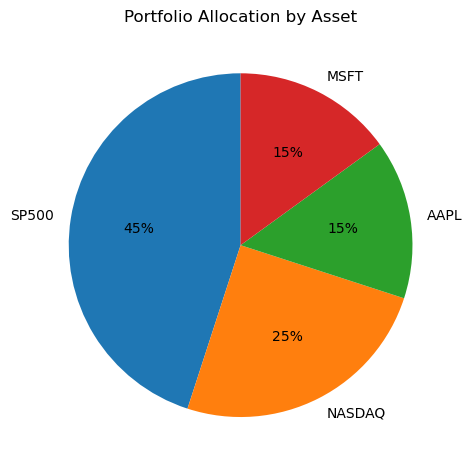

In [61]:
# -------------------------------
# 5.0 Visualisation (key plots)
# -------------------------------

# Portfolio weight allocation (communication of portfolio construction)
plt.figure()
plt.pie(WEIGHTS.values(), labels=WEIGHTS.keys(), autopct="%1.0f%%", startangle=90)
plt.title("Portfolio Allocation by Asset")
plt.tight_layout()
plt.show()


This visualisation shows the portfolio composition based on predefined
weights. The allocation emphasises broad market exposure through the S&P 500 and
NASDAQ indices, complemented by individual technology stocks. This diversified
structure reduces reliance on a single asset and helps stabilise portfolio
performance over time.


#### 5.2 Time-Series Visualisation

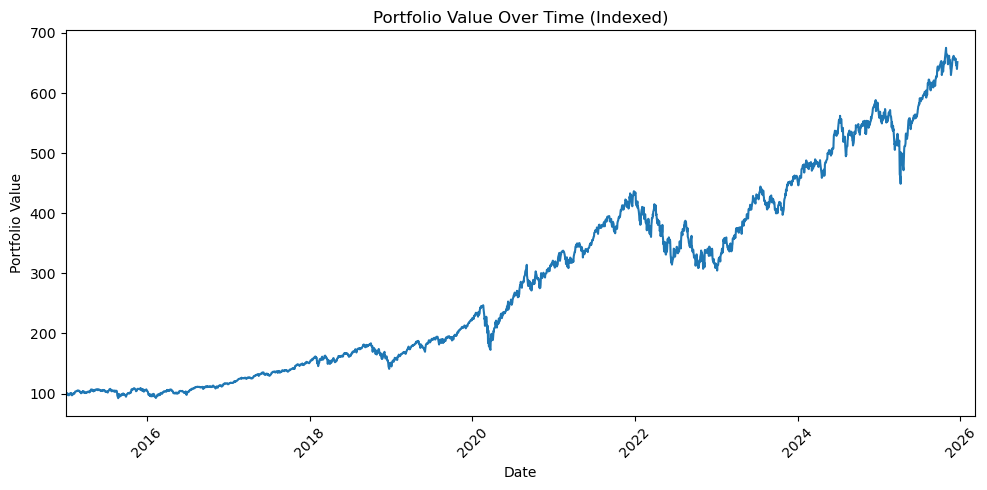

In [62]:
# Portfolio value over time (trend + volatility over the study period)
min_date = df_1nf["date"].min()
max_date = df_1nf["date"].max()
padding_days = int((max_date - min_date).days * 0.02)

plt.figure(figsize=(10, 5))
plt.plot(df_1nf["date"], df_1nf["portfolio"])
plt.title("Portfolio Value Over Time (Indexed)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.xlim(min_date, max_date + pd.Timedelta(days=padding_days))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The time-series plot reveals a clear long-term upward trend in portfolio value, with periods of increased volatility. Significant market events, like the COVID-19 market shock, are visible as sharp declines followed by recoveries. A pronounced decline is observed around early 2020, corresponding to the COVID-19 market shock, followed by a gradual recovery. Despite short-term fluctuations, the overall linear trend supports the suitability of regression-based modelling.


#### 5.3 Feature–Target Relationship

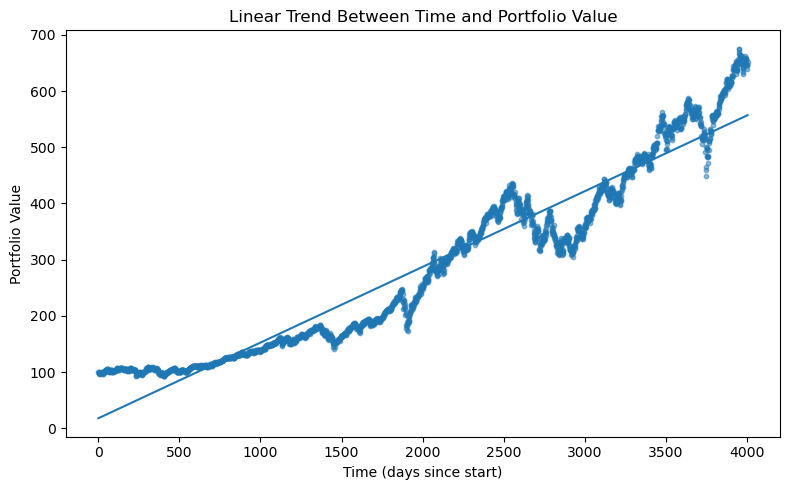

In [63]:
# Convert date to a numeric time index for regression modelling
df_1nf["t"] = (df_1nf["date"] - df_1nf["date"].min()).dt.days

# Scatter + fitted line to visualise linear relationship between time and portfolio value
coef = np.polyfit(df_1nf["t"], df_1nf["portfolio"], 1)
trend = np.poly1d(coef)

plt.figure(figsize=(8, 5))
plt.scatter(df_1nf["t"], df_1nf["portfolio"], s=10, alpha=0.5)
plt.plot(df_1nf["t"], trend(df_1nf["t"]))
plt.title("Linear Trend Between Time and Portfolio Value")
plt.xlabel("Time (days since start)")
plt.ylabel("Portfolio Value")
plt.tight_layout()
plt.show()


This visualisation highlights the relationship between time and portfolio value.
While short-term volatility is present, the data points cluster around an
increasing linear trend. This supports the use of linear regression as a baseline
model for capturing long-term portfolio growth.


#### 5.4 Most Informative Visualisation

Among the visualisations presented, the time-series plot of portfolio value is the most informative. It simultaneously conveys long-term growth, short-term volatility, and the impact of major market events. Without this visual representation, identifying trends and structural changes in the data would be significantly more difficult. The plot provides strong visual justification for the application of regression techniques in subsequent modelling.


### 6.0 Linear Regression Model

#### 6.1 Feature and Target Selection

In [64]:
# -------------------------------
# 6.0 Linear regression model (baseline)
# -------------------------------

# Feature (time index) and target (portfolio value)
X = df_1nf[["t"]]
y = df_1nf["portfolio"]


#### 6.2 Model Construction

In [65]:
# Time-series split: train first, test later (prevents data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit baseline linear regression model
model = LinearRegression()
model.fit(X_train, y_train);  # semicolon suppresses notebook object display


#### 6.3 Model Results

In [66]:
# Predict on the test split
y_pred = model.predict(X_test)

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")


RMSE: 97.04
MAE: 87.90
R²: -1.3239


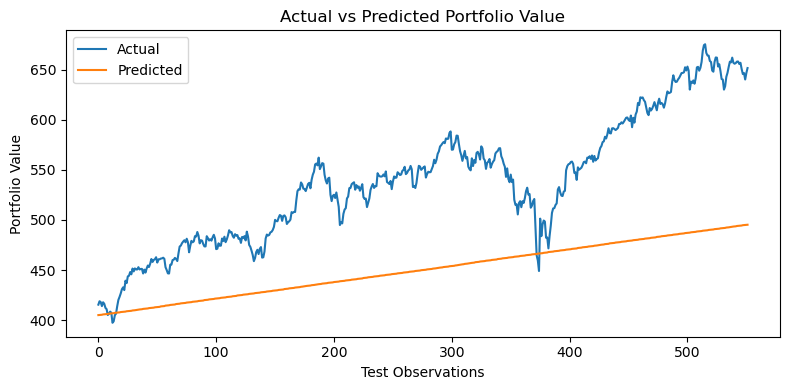

In [67]:
# Visual comparison of actual vs predicted values on the test split
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Portfolio Value")
plt.xlabel("Test Observations")
plt.ylabel("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()


This is a plot for actual versus predicted portfolio values over the test period. The x-axis represents the test observations (trading days), while the y-axis shows the indexed portfolio value. The predicted line illustrates the linear regression model’s ability to capture the long-term trend but not short-term market fluctuations.

### 7.0 Model Validation

#### 7.1 Validation Strategy

In [68]:
# -------------------------------
# 7.0 Validation (cross-validation)
# -------------------------------

# Cross-validation to assess model robustness across different splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))

print("Cross-validation RMSE per fold:", cv_rmse)
print("Mean CV RMSE:", cv_rmse.mean())


Cross-validation RMSE per fold: [43.00371594 42.88827579 44.542403   45.06812276 43.68615374]
Mean CV RMSE: 43.83773424584183


#### 7.2 Validation Results
The model was validated using 5-fold cross-validation. RMSE values across folds were consistent, ranging from approximately 42.9 to 45.1, with a mean RMSE of 43.84. The limited variation between folds suggest the model is stable and is good at generalising unseen data. The model is able to capture an underlying trend in the portfolio data rather than overfitting.

### 8.0 Feature Engineering

#### 8.1 Engineered Features

In [69]:
# -------------------------------
# 8.0 Feature engineering (polynomial features)
# -------------------------------

# Engineer polynomial features from time to capture non-linear trend behaviour
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

#### 8.2 Model Re-evaluation

In [70]:
# Fit and evaluate a polynomial regression model using the same time-series split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_poly, y, test_size=0.2, shuffle=False)

poly_model = LinearRegression()
poly_model.fit(X_train_p, y_train_p)

y_pred_p = poly_model.predict(X_test_p)

rmse_p = np.sqrt(mean_squared_error(y_test_p, y_pred_p))
r2_p = r2_score(y_test_p, y_pred_p)

print(f"Polynomial RMSE: {rmse_p:.2f}")
print(f"Polynomial R²: {r2_p:.4f}")

Polynomial RMSE: 36.31
Polynomial R²: 0.6747


Polynomial features were generated form the time variable to enable the model to capture non-linear trend behaviours.

### 9.0 Evaluation and Discussion

#### 9.1 Model Performance Evaluation
The performance of the linear regression model was evaluated using RMSE (Root Mean Squared Error), MAE MAE (Mean Absolute Error), and R². I selected RMSE to be the main evaluation metric because it penalises larger prediction errors which is useful for financial analysis where large deviations can have big impacts to the results. The linear model returned stable RMSE values across cross-validation folds (mean RMSE ≈ 43.8), meaning there is a consistent performance and robustness.

#### 9.2 Strengths and Limitations
The main strength of linear regression model is that its easy to interpret. The relationship between time and portfolio value is very clear, so we understand long-term growth trends easily. Cross-validation results further indicate that the model generalises well and is not too sensitive to the chosen train–test split.

However, the model has limitations. Financial time-series data can show volatility and sudden changes during market stress caused by certain events. These effects are not fully captured by a simple linear model as shown by increased residuals during volatile periods. Polynomial regression somewhat solves this problem, but it brings a risk of overfitting and reduced transparency.

#### 9.3 Contribution to the Domain
This project shows that linear regression is useful for a effective baseline model for analysing long-term trends in diversified equity portfolios. By aggregating multiple assets into a single portfolio, volatility is reduced and trend behaviour becomes more stable, improving model suitability.

#### 9.4 Transferability
The methodology I used in this project can be transferred to other domain-specific areas that also has time-dependant data with some trends. The same method can be used to other financial portfolios, market indices, or other economic studies. Beyond the field of finance, this way of data pre-processing, statistical analysis, visualisation, regression modelling, and validation can be used in fields such as sustainability analysis, demand forecasting, and population growth modelling. However, for research that needs short-term prediction or capturing abrupt structural changes, more complex models may be required.

### 10.0 Originality and Extension
This project goes beyond basic linear regression because I applied it to a real-world situation where I combined different financial datasets and evaluated model performance at the portfolio level rather than on individual assets alone. The inclusion of cross-validation and polynomial feature engineering further demonstrates a critical assessment of model robustness and accuracy, going beyond a minimal implementation.

### 11.0 Conclusion
This project studied the use of linear regression on long-term trends in a diversified portfolio. Through data pre-processing and analysis, we learn that linear regression is an effective and interpretable baseline model to capture long-term portfolio growth trends. While more complex models can improve accuracy, linear regression is still valuable for its simplicity, robustness and transferability to other time-series data.